# 8. Analiza danych przestrzennych z wykorzystaniem pakietów GeoPandas i PySAL

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import libpysal as ps
import pointpats as pp
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Dodanie poprzednio przygotowanych funkcji

In [2]:
def f_function_poisson(d, intensity):
    """
    Parameters
    -------
    d: array
        Macierz zawierająca odległości, dla których ma zostać wyznaczona wartość funkcji F.
    intensity: float
        Liczba dodatnia określająca intensywność jednorodnego procesu Poissona.

    Returns
    -------
    f: DataFrame
        Tablica zawierająca dwie kolumny:
        - "D" - zawierającą unikalne wartości odległości do najbliższego sąsiada uszeregowane od najmniejszej do największej wartości, dla których wyliczone zostały wartości funkcji F,
        - "F" - zawierającą wyliczone wartości funkcji F.
    """  
    
    F = np.zeros(len(d))
    
    
    for i in range(len(d)):
        F[i] = 1 - (math.exp(-intensity*d[i]*d[i]*math.pi))
    

    f=pd.DataFrame(data = {'D':d,'F':F})
    return(f)

def g_function_poisson(d, intensity):
    G = np.zeros(len(d))
    
    
    for i in range(len(d)):
        G[i] = 1 - (math.exp(-intensity*d[i]*d[i]*math.pi))
    

    g=pd.DataFrame(data = {'D':d,'G':G})
    return(g)

### Import i przygotowanie danych

In [3]:
Powiaty = gpd.read_file(".\Data\Powiaty.zip")
Points1 = gpd.read_file(".\Data\points_1.zip")
Points2 = gpd.read_file(".\Data\points_2.zip")
Points3 = gpd.read_file(".\Data\points_3.zip")
Points4 = gpd.read_file(".\Data\points_4.zip")
Points5 = gpd.read_file(".\Data\points_5.zip")

Kraj = gpd.GeoDataFrame.dissolve(Powiaty)
#Kraj["Nazwa"][0] = "Polska"

### Badanie intensywności procesów punktowych metodą szacowania lokalnego

Funkcja `point_count_on_subregions()`, zlicza punkty w obrębie podobszarów.

Funkcja `intensity_on_subregions()`, oblicza intensywność procesu punktowego w obrębie podobszarów.

Wykorzystano przygotowane funkcje do zbadania intensywności rozkładów punktów z plików points_1.zip i points_2.zip na obszarze poszczegolnych powiatów.

#### a) Przygotowanie funkcji

In [4]:
def point_count_on_subregions(points, subregions):
    """
    Parameters
    -------
    points: GeoSeries
        Tablica zawierająca punkty zapisane jako obiekty shapely.geometry.point.Point.
    subregions: GeoDataFrame
        Tablica zawierająca geometrie podobszarów zapisane jako obiekty shapely.geometry.polygon.Polygon.
    Returns
    -------
    counts: Series
        Seria Pandas zawierająca liczbą punktów przypisanych do każdego z podobszarów.
    """
    
    Series = np.zeros(len(subregions))
    
    
    for i in range(len(subregions)):
        Series[i] = sum(points.within(subregions["geometry"][i]))
        
    Series = pd.Series(Series)

    return(Series)

def intensity_on_subregions(points, subregions):
    """
    Parameters
    -------
    points: GeoSeries
        Tablica zawierająca punkty zapisane jako obiekty shapely.geometry.point.Point.
    subregions: GeoDataFrame
        Tablica zawierająca geometrie podobszarów zapisane jako obiekty shapely.geometry.polygon.Polygon.
    Returns
    -------
    intensity: Series
        Seria Pandas zawierająca intensywność przypisaną do każdego z podobszarów.
    """
    
    Area = subregions.area
    Series = np.zeros(len(subregions))
    
    PC = point_count_on_subregions(points, subregions)
    
    
    for i in range(len(subregions)):
        Series[i] = PC[i]/Area[i]
    
    
    Series = pd.Series(Series)
    return(Series)

#### b) Wygenerowanie danych

In [5]:
Powiaty["PC_1"] = point_count_on_subregions(Points1, Powiaty)
Powiaty["I_1"] = intensity_on_subregions(Points1, Powiaty)

Powiaty["PC_2"] = point_count_on_subregions(Points2, Powiaty)
Powiaty["I_2"] = intensity_on_subregions(Points2, Powiaty)

#### c) Wizualizacja

Text(1026.9267676767674, 0.5, 'Y[m]')

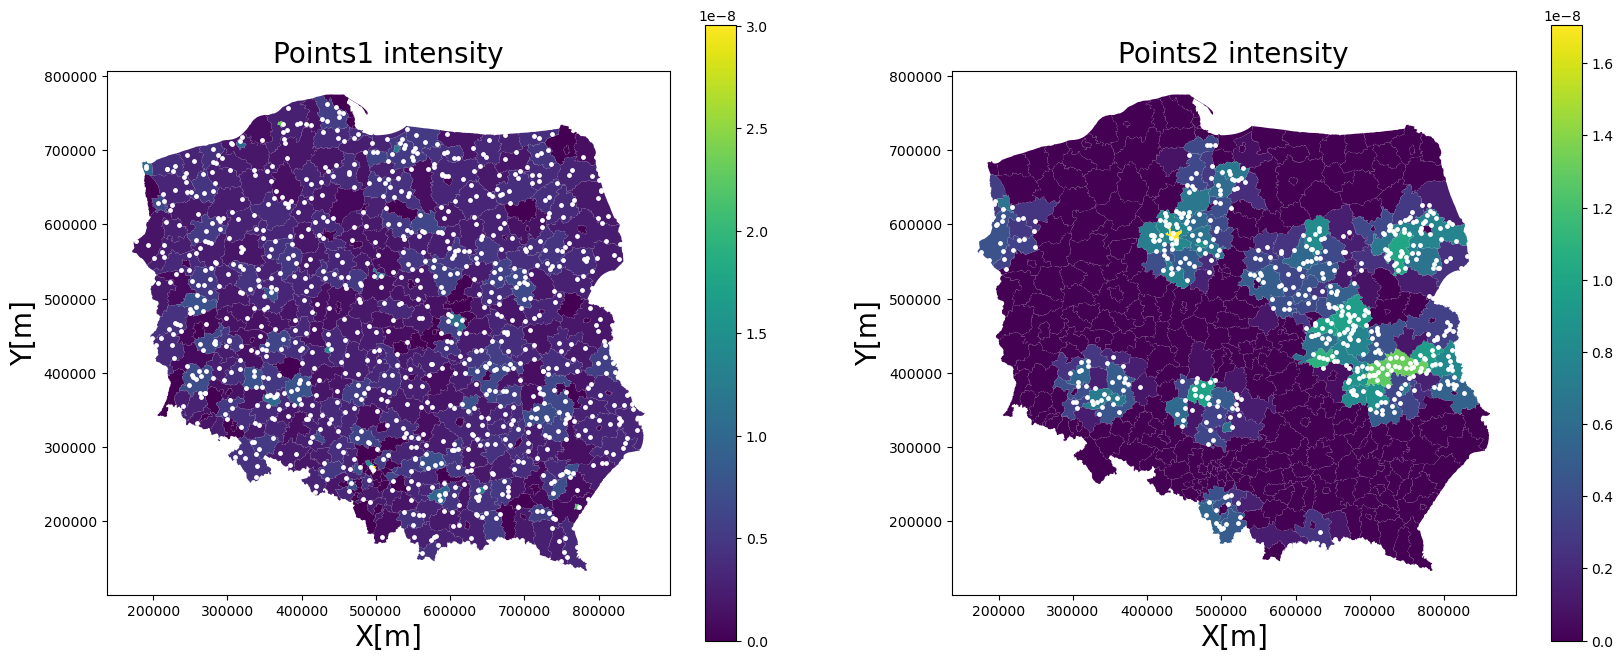

In [6]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,20))

Powiaty.plot(column = "I_1", ax = ax1, legend=True, legend_kwds={'shrink': 0.4})
Points1.plot(ax = ax1, color = "white", markersize = 6)
ax1.set_title("Points1 intensity", fontsize=20)
ax1.set_xlabel("X[m]", fontsize = 20)
ax1.set_ylabel("Y[m]", fontsize = 20)

Powiaty.plot(column = "I_2", ax = ax2, legend=True, legend_kwds={'shrink': 0.4})
Points2.plot(ax = ax2, color = "white", markersize = 6)
ax2.set_title("Points2 intensity", fontsize=20)
ax2.set_xlabel("X[m]", fontsize = 20)
ax2.set_ylabel("Y[m]", fontsize = 20)

### Funkcja G
Wykorzystując funkcję `pointpats.distance_statistics.g()` przygotowano funkcję `g_function()`, która będzie generować dane niezbędne do wykonania wykresu funkcji G analizowanego rozkładu punktów.

Wykorzystano przygotowane funkcje do wygnenerowania danych dla rozkładów punktów z plików points_3.zip, points_4.zip i points_5.zip. 

#### a) Przygotowanie funkcji

In [7]:
def g_function(points, intervals):
    """
    Parameters
    -------
    points: GeoSeries
        Tablica zawierająca punkty zapisane jako obiekty shapely.geometry.point.Point.
    intervals: int
        Liczba dodatnia określająca na ile części ma zostać podzielony dystans do najdalszej odległosci do najbliższego sąsiada.
    Returns
    -------
    g: DataFrame
        Tablica zawierająca dwie kolumny:
        - "D" - zawierającą unikalne wartości odległości do najbliższego sąsiada uszeregowane od najmniejszej do największej wartości, dla których wyliczone zostały wartości funkcji G,
        - "G" - zawierającą wyliczone wartości funkcji G.
    """
    
    x = points["geometry"].x
    y = points["geometry"].y
    
    DF = pd.DataFrame(data = {"x": x, "y": y})
    
    Distances = pp.distance_statistics.g(coordinates = DF, support = intervals)
    
    df = pd.DataFrame(data = {"D": Distances[0], "G": Distances[1]})
     
    return(df)

#### b) Wygenerowanie danych

In [8]:
Points3_G_observed = g_function(Points3, 100)
intensity3 = intensity_on_subregions(Points3,Kraj)
Points3_G_theoretical = g_function_poisson(Points3_G_observed["D"], intensity3[0])

Points4_G_observed = g_function(Points4, 100)
intensity4 = intensity_on_subregions(Points4,Kraj)
Points4_G_theoretical = g_function_poisson(Points4_G_observed["D"], intensity4[0])

Points5_G_observed = g_function(Points5, 100)
intensity5 = intensity_on_subregions(Points5,Kraj)
Points5_G_theoretical = g_function_poisson(Points5_G_observed["D"], intensity5[0])

##### c) Wizualizacja

Text(0.5, 1.0, 'G function Points5')

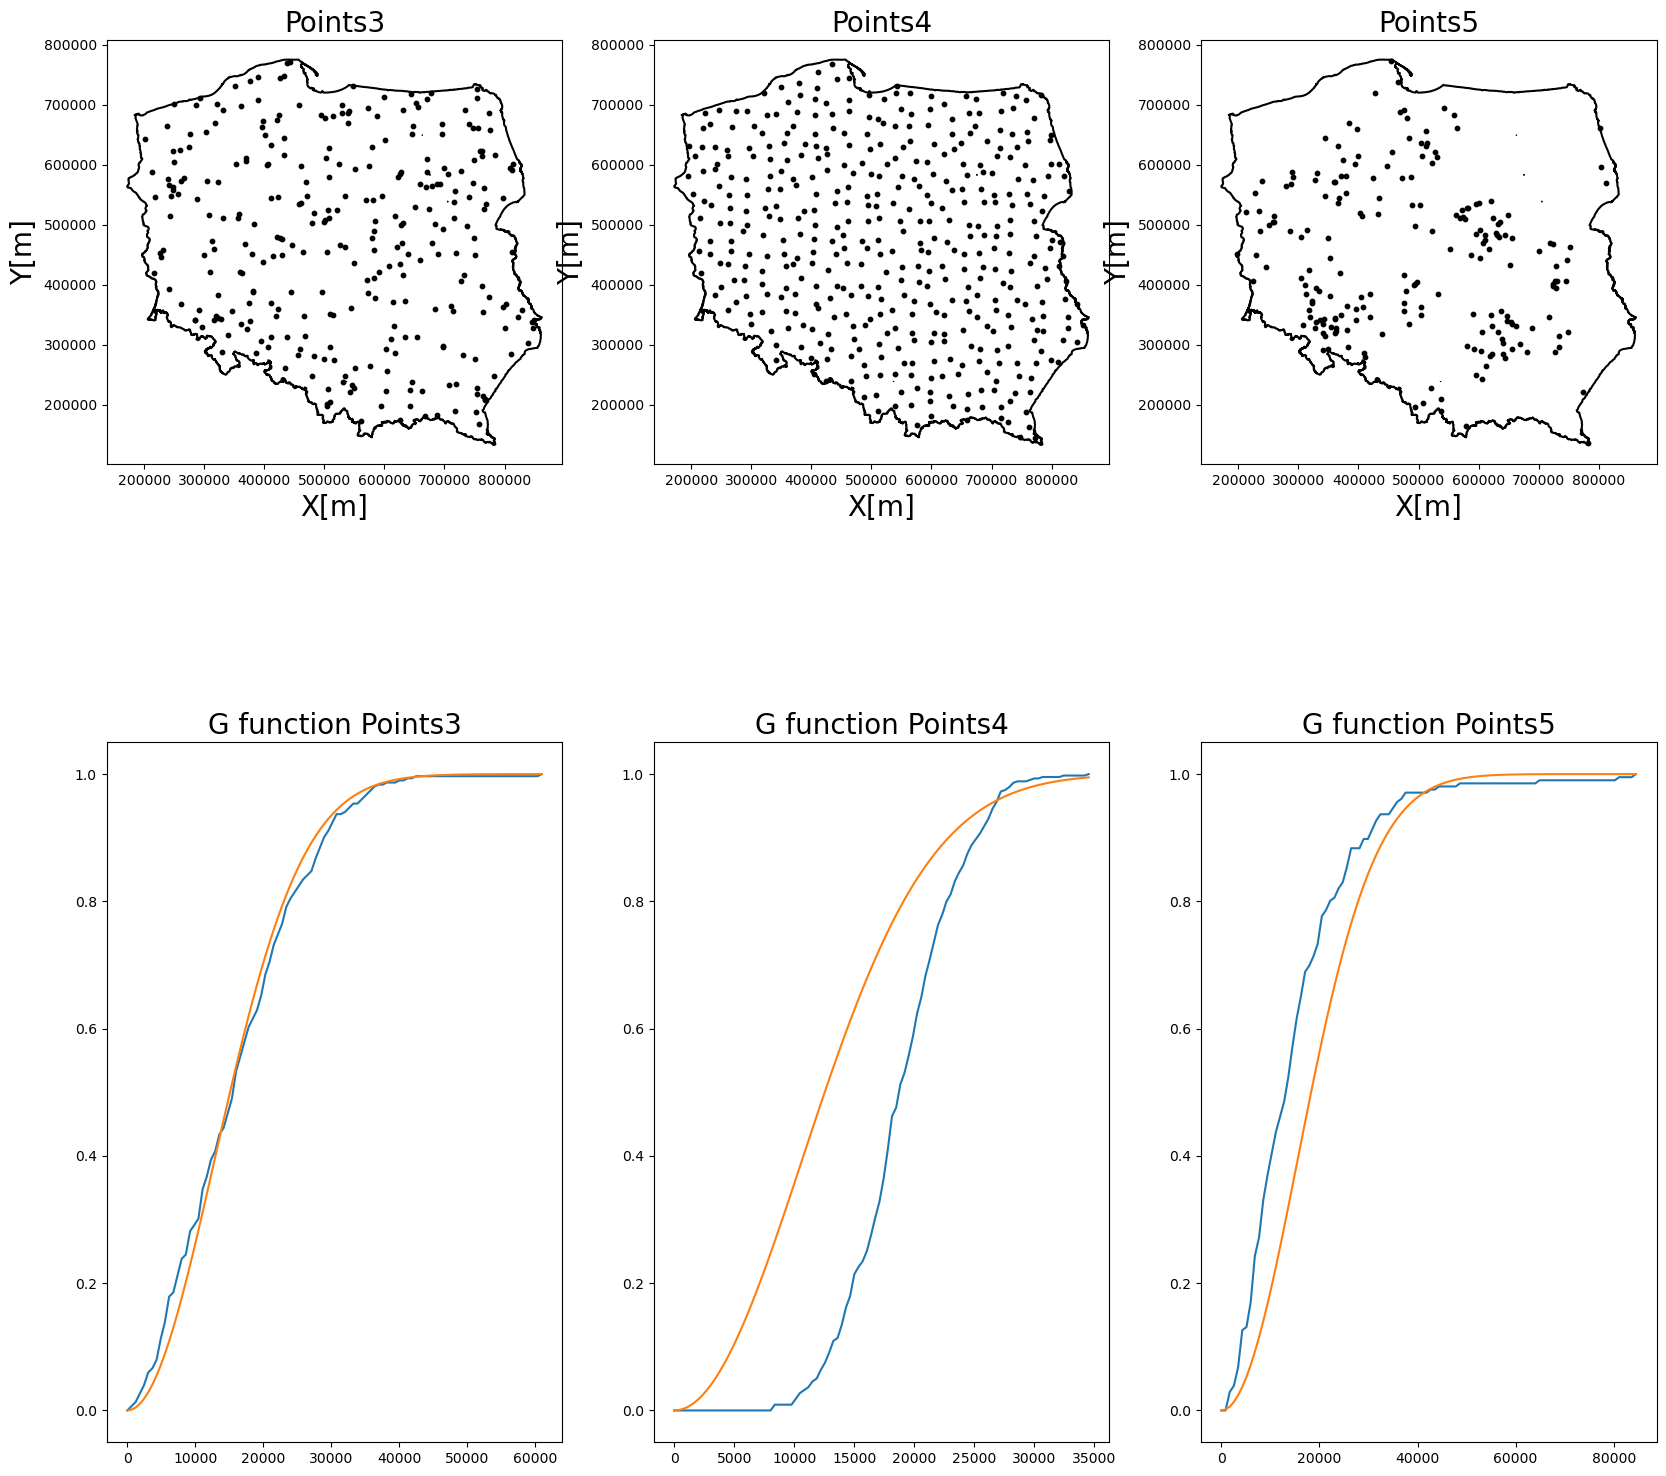

In [9]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(20,20))


Points3.plot(ax=ax1, color="black", markersize = 10)
Kraj.boundary.plot(ax=ax1, color = 'black')
ax1.set_title("Points3", fontsize = 20)
ax1.set_xlabel("X[m]", fontsize = 20)
ax1.set_ylabel("Y[m]", fontsize = 20)

Points4.plot(ax=ax2, color="black", markersize = 10)
Kraj.boundary.plot(ax=ax2, color = 'black')
ax2.set_title("Points4", fontsize = 20)
ax2.set_xlabel("X[m]", fontsize = 20)
ax2.set_ylabel("Y[m]", fontsize = 20)

Points5.plot(ax=ax3, color="black", markersize = 10)
Kraj.boundary.plot(ax=ax3, color = 'black')
ax3.set_title("Points5", fontsize = 20)
ax3.set_xlabel("X[m]", fontsize = 20)
ax3.set_ylabel("Y[m]", fontsize = 20)


ax4.plot(Points3_G_observed["D"], Points3_G_observed["G"])
ax4.plot(Points3_G_theoretical["D"], Points3_G_theoretical["G"])
ax4.set_title("G function Points3", fontsize = 20)

ax5.plot(Points4_G_observed["D"], Points4_G_observed["G"])
ax5.plot(Points4_G_theoretical["D"], Points4_G_theoretical["G"])
ax5.set_title("G function Points4", fontsize = 20)

ax6.plot(Points5_G_observed["D"], Points5_G_observed["G"])
ax6.plot(Points5_G_theoretical["D"], Points5_G_theoretical["G"])
ax6.set_title("G function Points5", fontsize = 20)

### Zadanie 4: Funkcja F (15 pkt)

Wykorzystując funkcję `pointpats.distance_statistics.f()` przygotowano funkcję `f_function()`, która będzie generować dane niezbędne do wykonania wykresu funkcji F analizowanego rozkładu punktów.

Wykorzystano przygotowane funkcje do wygnenerowania danych dla rozkładów punktów z plików points_3.zip, points_4.zip i points_5.zip. 

#### a) Przygotowanie funkcji

In [10]:
def f_function(points, intervals, polygon):
    """
    Parameters
    -------
    points: GeoSeries
        Tablica zawierająca punkty zapisane jako obiekty shapely.geometry.point.Point.
    intervals: int
        Liczba dodatnia określająca na ile części ma zostać podzielony dystans do najdalszej odległosci do najbliższego sąsiada.
    polygon: Polygon
        Obszar, na którym mają zostać wygenerowane punkty procesu testowego.
        
    Returns
    -------
    f: DataFrame
        Tablica zawierająca dwie kolumny:
        - "D" - zawierającą unikalne wartości odległości do najbliższego sąsiada uszeregowane od najmniejszej do największej wartości, dla których wyliczone zostały wartości funkcji F,
        - "F" - zawierającą wyliczone wartości funkcji F.
    """
    
    x = points["geometry"].x
    y = points["geometry"].y
    
    DF = pd.DataFrame(data = {"x": x, "y": y})

    
    Distances = pp.distance_statistics.f(coordinates = DF, support = intervals, hull = polygon)
    
    df = pd.DataFrame(data = {"D": Distances[0], "F": Distances[1]})
    
    return(df)

#### b) Wygenerowanie danych

In [11]:
Points3_F_observed = f_function(Points3, 100, Kraj["geometry"][0])
Points3_F_theoretical = f_function_poisson(Points3_F_observed["D"], intensity3[0])

Points4_F_observed = f_function(Points4, 100, Kraj["geometry"][0])
Points4_F_theoretical = f_function_poisson(Points4_F_observed["D"], intensity4[0])

Points5_F_observed = f_function(Points5, 100, Kraj["geometry"][0])
Points5_F_theoretical = f_function_poisson(Points5_F_observed["D"], intensity5[0])

#### c) Wizualizacja

Text(0.5, 1.0, 'F function Points5')

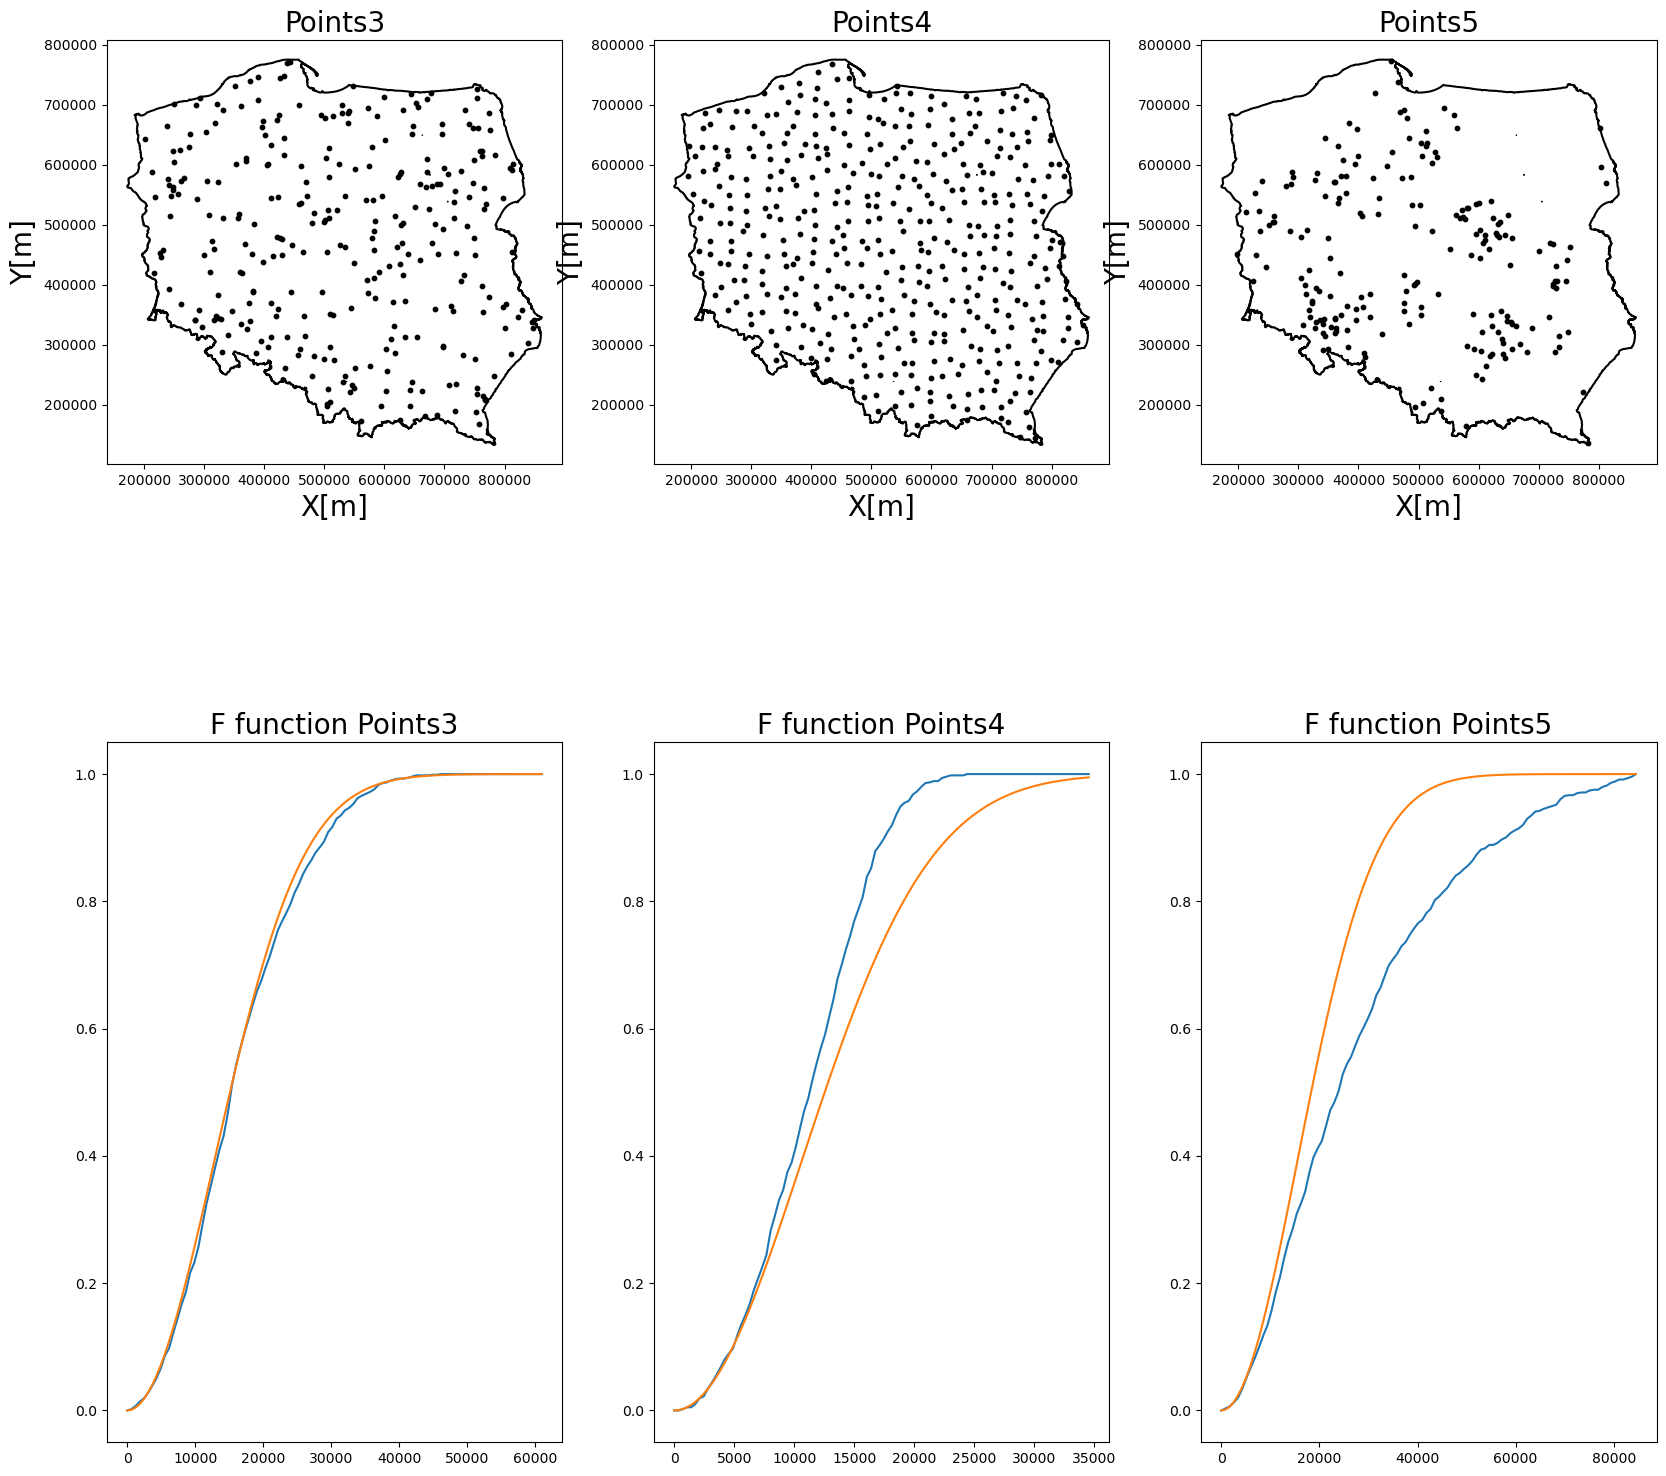

In [12]:
fig, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(20,20))

Points3.plot(ax = ax1, color = 'black', markersize = 10)
Kraj.boundary.plot(ax=ax1, color = "black")
ax1.set_title("Points3", fontsize = 20)
ax1.set_xlabel("X[m]", fontsize = 20)
ax1.set_ylabel("Y[m]", fontsize = 20)


Points4.plot(ax=ax2, color="black", markersize = 10)
Kraj.boundary.plot(ax=ax2, color = "black")
ax2.set_title("Points4", fontsize = 20)
ax2.set_xlabel("X[m]", fontsize = 20)
ax2.set_ylabel("Y[m]", fontsize = 20)

Points5.plot(ax=ax3, color="black", markersize = 10)
Kraj.boundary.plot(ax=ax3, color = "black")
ax3.set_title("Points5", fontsize = 20)
ax3.set_xlabel("X[m]", fontsize = 20)
ax3.set_ylabel("Y[m]", fontsize = 20)


ax4.plot(Points3_F_observed["D"],Points3_F_observed["F"] )
ax4.plot(Points3_F_theoretical["D"], Points3_F_theoretical["F"])
ax4.set_title("F function Points3", fontsize = 20)

ax5.plot(Points4_F_observed["D"],Points4_F_observed["F"] )
ax5.plot(Points4_F_theoretical["D"], Points4_F_theoretical["F"])
ax5.set_title("F function Points4", fontsize = 20)

ax6.plot(Points5_F_observed["D"],Points5_F_observed["F"] )
ax6.plot(Points5_F_theoretical["D"], Points5_F_theoretical["F"])
ax6.set_title("F function Points5", fontsize = 20)